In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 23 11:14:00 2023

@author: al005366
"""
import logging

# %%
# Import necessary libraries
import os
from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.neural_network import MLPRegressor
from statsmodels.tsa.api import VAR

matplotlib.style.use('ggplot')

# Define the size of the DataFrame
size = 400

In [2]:
df = pd.read_csv('./data/data_processed_quaterly_DE.csv') # fx, pol_rate, cpi_yoy_L1, bankCreditPnfs_yoy_L2
df.set_index(pd.to_datetime(df['date']), inplace=True)
df = df.drop('date', axis=1)
df.head()


,resPropPrice,fx,dsrPnfs,dsrHousehold,dsrNfc,policyRate,UStermSpread,financialStressIndex,fx_std,bankCreditPnfs_yoy_L1,...,totalCreditPnfs2GDP_yoy_L1,bankCreditPnfs_yoy_L2,totalCreditPnfsLCY_yoy_L2,totalCreditPnfs2GDP_yoy_L2,cpi_yoy_L1,financialConditionIndex,EAtermspread,USpolicyRate,financialStressIndex_movingAverage,is_systemic_crisis
date,,,,,,,,,,,,,,,,,,,,,
1970-04-01,123.2700,1.860088,NaN,NaN,NaN,7.500000,NaN,0.10604,0.161265,15.414753,...,1.822600,15.841755,15.365390,2.916160,2.929191,NaN,NaN,7.882755,NaN,0.0
1970-07-01,124.3391,1.856615,NaN,NaN,NaN,7.085859,NaN,0.10064,0.038282,15.830040,...,1.334951,15.414753,14.502976,1.822600,3.368295,NaN,NaN,6.698687,NaN,0.0
1970-10-01,124.7134,1.858916,NaN,NaN,NaN,6.616162,NaN,0.05876,0.024770,14.827194,...,0.607533,15.830040,14.855307,1.334951,3.503313,NaN,NaN,5.577475,NaN,0.0
1971-01-01,125.7255,1.857594,NaN,NaN,NaN,6.000000,NaN,0.06502,0.003036,9.975039,...,-1.298701,14.827194,14.103921,0.607533,3.945319,NaN,NaN,3.850825,NaN,0.0
1971-04-01,129.8377,1.826105,NaN,NaN,NaN,5.000000,NaN,0.06414,0.031660,9.517005,...,-1.789976,9.975039,11.554189,-1.298701,4.267882,NaN,NaN,4.551020,NaN,0.0


In [3]:
regressors = [ 'fx', 'policyRate', 'bankCreditPnfs_yoy_L2', 'cpi_yoy_L1']
target = 'financialStressIndex_movingAverage'

In [4]:
# Define model specifications
mod_1 = ['fx']
mod_2 = mod_1 + ['policyRate', 'bankCreditPnfs_yoy_L2', 'cpi_yoy_L1']
mod_3 = mod_1 + ['policyRate']
mod_4 = mod_1 + ['bankCreditPnfs_yoy_L2']

#mod_6 = mod_2 + 'USpolicyRate'

# Store models in a dictionary
models = {
    'model_1': mod_1,
    'model_2': mod_2,
    'model_3': mod_3,
    'model_4': mod_4
 #   'model_5': mod_5,
}

In [5]:
df.last_valid_index()

Timestamp('2024-07-01 00:00:00')

In [6]:
# Define training and test dates
train_start_date = '1972-10-01'
train_end_date = '2015-12-01'
test_start_date_1 = '2016-01-01'
test_end_date_1 = '2024-01-01'

# Split the data into training and testing sets
df_train = df.loc[(df.index >= train_start_date) & (df.index <= train_end_date), :].copy()
train_x = {mname: pd.DataFrame() for mname in models.keys()}
# Populate train_x with training data
for mname, varsname in models.items():
    train_x[mname] = df_train[varsname].dropna().copy()
    train_x[mname] = sm.add_constant(train_x[mname])

df_test_1 = df.loc[(df.index >= test_start_date_1) & (df.index <= test_end_date_1), :].copy()
test_x_1 = {mname: pd.DataFrame() for mname in models.keys()}
# Populate test_x_1 with test data
for mname, varsname in models.items():
    test_x_1[mname] = df_test_1[varsname].dropna().copy()
    test_x_1[mname] = sm.add_constant(test_x_1[mname])


# Define the target variable
y = df[['financialStressIndex_movingAverage']].copy()
train_y = y[y.index.isin(df_train[varsname].dropna().index.tolist())].copy()
test_y_1 = df['financialStressIndex_movingAverage'][df.index.isin(df_test_1.index.tolist())].copy()
#test_y_2 = df['financialConditionIndex'][df.index.isin(df_test_2.index.tolist())].copy()

In [7]:
# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Define models and hyperparameters for benchmarking
ridge_model = Ridge()
ridge_params_grid = {"alpha": [100, 1e0, 1e-5]}

kernel_ridge_model = KernelRidge()
kr_params_grid = {"alpha": [100, 1e0, 1e-5],
                "kernel": ['linear', 'rbf'],
                "gamma": [1e0, 1e-5]}

rf_model = RandomForestRegressor()
rf_params_grid = {
    'bootstrap': [True],
    'max_depth': [80, 110],
    'n_estimators': [100, 1000],
    'random_state': [0]
}

gbr_model = GradientBoostingRegressor()
gbr_params_grid = {
    "n_estimators": [10, 500],
    "learning_rate": [0.0001, 1.0],
    "loss": ["squared_error"],
    "random_state": [0]
}

xgb_model = xgb.XGBRegressor()
xgb_params_grid = {
    'subsample': [1],
    'max_depth': [3, 5],
    'gamma': np.linspace(0, 1, 3),
    'colsample_bytree': [0.15]
}

mlp_model = MLPRegressor(max_iter=1000)
mlp_params_grid = {
    'hidden_layer_sizes': [(50, 50), (100, 200)],
    'activation': ['tanh'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0, 0.05],
    'learning_rate': ['constant'],
}

benchmarking_dict = {
    'rf': {'model': rf_model, 'param_grid': rf_params_grid},
    'ridge':{'model': ridge_model, 'param_grid': ridge_params_grid},
    #'kernel_ridge': {'model': kernel_ridge_model, 'param_grid': kr_params_grid},
    #'gbr':{'model': gbr_model, 'param_grid': gbr_params_grid},
    'xgb': {'model': xgb_model, 'param_grid': xgb_params_grid},
    #'mlp': {'model': mlp_model, 'param_grid': mlp_params_grid}
}

# Specify horizons and metrics
horizon = ['1m', '3m', '12m']
metric = ['r2', 'rmse_1', 'rmse_2']

# Create a dictionary to store results
res = dict()

In [8]:
import os
wd = os.getcwd()
mlflow.set_tracking_uri(f"sqlite:///{wd}/mlflow/mlflow.db")
# mlflow ui --port 5000 --backend-store-uri 'sqlite:///c:/git/eu_sdfa_forecastingTools/mlflow.db'

In [9]:
# Get the current date
today = datetime.today().date().isoformat()
today_str = today.replace('-', '')
#mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns --port 6000
# Set the tracking URI to your local tracking server
#mlflow.set_tracking_uri("http://localhost:6000")

# Define experiment name
experiment_name = f"{today}-benchmarking-eusdfa-123"

# Check if the experiment exists
experiment = mlflow.get_experiment_by_name(experiment_name)

if experiment:
    experiment_id = experiment.experiment_id
else:
    # Create the experiment
    experiment_id = mlflow.create_experiment(experiment_name)

print(f"Using experiment ID: {experiment_id}")

Using experiment ID: 1


In [10]:
# Loop through each model for benchmarking
for model in benchmarking_dict.keys():
    # Initialize results dataframe         
    res[model] = pd.DataFrame(index=models.keys(), columns=pd.MultiIndex.from_product([horizon, metric], names=['horizon', 'metric']))
    # Loop through each target horizon
    for h in train_y.columns:
        hh = h.split('_')[-1].split('F')[-1] + 'm'
        # Loop through each model specification
        for modname, modvars in models.items():
            # Start an MLflow run
            with mlflow.start_run(run_name=f"inflation-{today_str}-{model}-{h}-{modname}", experiment_id=experiment_id):
                # Logging information    
                print(f'\n Model: {model} \n Spec: {modname} \n Spec vars: {modvars} \n Horizon: {hh}')
                mlflow.log_param("Model", model)
                mlflow.log_param("Spec", modname)
                mlflow.log_param("Spec_vars", modvars)
                mlflow.log_param("Horizon", hh)
                
                # Grid search for hyperparameter tuning
                model_paramSearch = GridSearchCV(benchmarking_dict[model]['model'], 
                                                param_grid=benchmarking_dict[model]['param_grid'],
                                                cv=tscv)
                model_paramSearch.fit(train_x[modname], train_y[h])
                best_params = model_paramSearch.best_params_
                
                # Fit the model with the best hyperparameters
                res_fit = benchmarking_dict[model]['model'].set_params(**model_paramSearch.best_params_).fit(train_x[modname], train_y[h])

                # Log the resulting model
                mlflow.sklearn.log_model(res_fit, "model")

                # Log the best parameters
                for param, value in best_params.items():
                    mlflow.log_param(param, value)
                
                # Make predictions on test data
                pred_o = res_fit.predict(test_x_1[modname])
                pred_i = res_fit.predict(train_x[modname])
                
                try:
                    coeff_ = pd.DataFrame(res_fit.coef_, index=train_x[modname].columns, columns=['coeff'])
                except Exception:
                    coeff_ = []
                
                # Calculate evaluation metrics
                r2 = r2_score(train_y[h], pred_i)
                rmse_1 = mean_squared_error(test_y_1, pred_o, squared=False)
                res[model].loc[modname, (hh, 'r2')] = r2
                res[model].loc[modname, (hh, 'rmse_1')] = rmse_1

                # Log metrics
                mlflow.log_metric("r2", r2)
                mlflow.log_metric("rmse_1", rmse_1)

                # Save results to a pickle file
                res2pkl = {
                    'fit': res_fit,
                    'pred_o': pred_o,
                    'train_x': train_x[modname],
                    #'test_x': test_x[modname],
                    'test_x_1': test_x_1[modname],
                    #'test_x_2': test_x_2[modname],
                    'train_y': train_y[h],
                    'test_y_1': test_y_1,
                    'pred_i': pred_i,
                    'coeff_': coeff_,
                    'r2': res[model].loc[modname, (hh, 'r2')],
                    'rmse_1': res[model].loc[modname, (hh, 'rmse_1')],
                }
            
            #with open(f'{models_folder}{model}\\{model}_{modname}_{hh}.pkl','wb') as f:
            #    pickle.dump(res2pkl, f)
    
    # Save results to an Excel file        
    #res[model].to_excel(res_folder + f'{model}_V2.xlsx', sheet_name='data')

# Save overall results to a pickle file               
#with open(res_folder + '\\results_models_V2.pkl', 'wb') as f:
#    pickle.dump(res, f)

print("Experiment completed and logged.")


 Model: rf 
 Spec: model_1 
 Spec vars: ['fx'] 
 Horizon: movingAveragem


2024/07/29 18:20:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 Model: rf 
 Spec: model_2 
 Spec vars: ['fx', 'policyRate', 'bankCreditPnfs_yoy_L2', 'cpi_yoy_L1'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:20:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: rf 
 Spec: model_3 
 Spec vars: ['fx', 'policyRate'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:20:34 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: rf 
 Spec: model_4 
 Spec vars: ['fx', 'bankCreditPnfs_yoy_L2'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:20:49 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: ridge 
 Spec: model_1 
 Spec vars: ['fx'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:20:53 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: ridge 
 Spec: model_2 
 Spec vars: ['fx', 'policyRate', 'bankCreditPnfs_yoy_L2', 'cpi_yoy_L1'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:20:57 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: ridge 
 Spec: model_3 
 Spec vars: ['fx', 'policyRate'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:21:01 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: ridge 
 Spec: model_4 
 Spec vars: ['fx', 'bankCreditPnfs_yoy_L2'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:21:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: xgb 
 Spec: model_1 
 Spec vars: ['fx'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:21:11 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: xgb 
 Spec: model_2 
 Spec vars: ['fx', 'policyRate', 'bankCreditPnfs_yoy_L2', 'cpi_yoy_L1'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:21:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: xgb 
 Spec: model_3 
 Spec vars: ['fx', 'policyRate'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:21:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: xgb 
 Spec: model_4 
 Spec vars: ['fx', 'bankCreditPnfs_yoy_L2'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:21:28 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Experiment completed and logged.


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [11]:
# Set the tracking URI, otherwise mlflow will not find your runs
experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
print(experiment_id)
runs = mlflow.search_runs(experiment_ids=[experiment_id])#filter_string=f"tags.mlflow.experiment_name = '{experiment_name}'")
#print(runs)
best_run = runs.loc[runs["metrics.r2"].idxmax()]
print(best_run)
run_id = best_run["run_id"]
# %% Load model for the given run
path = f"runs:/{run_id}/model"
model = mlflow.sklearn.load_model(path)
print(model)

1
run_id                                            ea764eebc9d940e782701c1c75fb5a33
experiment_id                                                                    1
status                                                                    FINISHED
artifact_uri                     file:///c:/git/eu_sdfa_forecastingTools/mlruns...
start_time                                        2024-07-29 16:20:03.083000+00:00
end_time                                          2024-07-29 16:20:20.203000+00:00
metrics.r2                                                                 0.95415
metrics.rmse_1                                                            0.036423
params.Model                                                                    rf
params.Spec_vars                 ['fx', 'policyRate', 'bankCreditPnfs_yoy_L2', ...
params.colsample_bytree                                                       None
params.Horizon                                                      movingAveragem
pa

In [12]:
pred_best = model.predict(test_x_1['model_2'])

In [13]:
pred_best

array([0.07444584, 0.07671943, 0.07610131, 0.07771315, 0.07776971,
       0.0873855 , 0.08778491, 0.08871181, 0.09013829, 0.08832541,
       0.08870602, 0.09037252, 0.08919958, 0.08720835, 0.08778739,
       0.08763395, 0.07995187, 0.0891412 , 0.07749577, 0.07746403,
       0.07922585, 0.08907625, 0.09021647, 0.15285048, 0.18049046,
       0.1778733 , 0.20389805, 0.21298532, 0.20863428, 0.21028179,
       0.21353787, 0.20980204, 0.1779985 ])

In [14]:
pred_best_df = pd.DataFrame(index = test_y_1.index, columns = ['pred'])
pred_best_df['pred']= pred_best

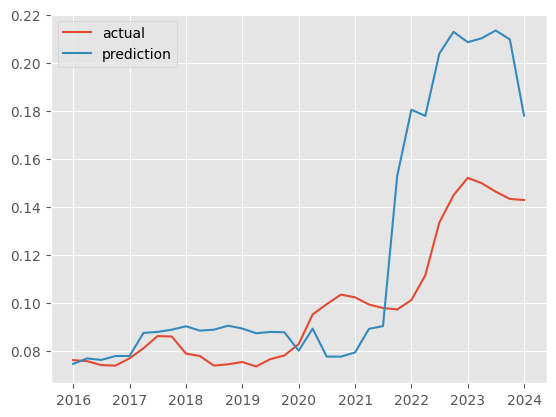

In [15]:
plt.plot(test_y_1)
plt.plot(pred_best_df)
plt.legend(['actual','prediction'])

In [16]:
import tempfile
import shap

c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
test_x = test_x_1
test_y=test_y_1


 Model: ols 
 Spec: model_1 
 Spec vars: ['fx'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:21:54 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: ols 
 Spec: model_2 
 Spec vars: ['fx', 'policyRate', 'bankCreditPnfs_yoy_L2', 'cpi_yoy_L1'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:21:58 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: ols 
 Spec: model_3 
 Spec vars: ['fx', 'policyRate'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:22:02 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: ols 
 Spec: model_4 
 Spec vars: ['fx', 'bankCreditPnfs_yoy_L2'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:22:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 


 Model: rf 
 Spec: model_1 
 Spec vars: ['fx'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:22:21 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 

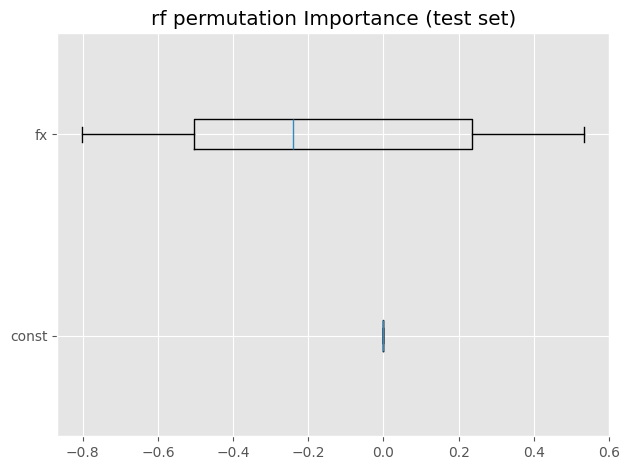

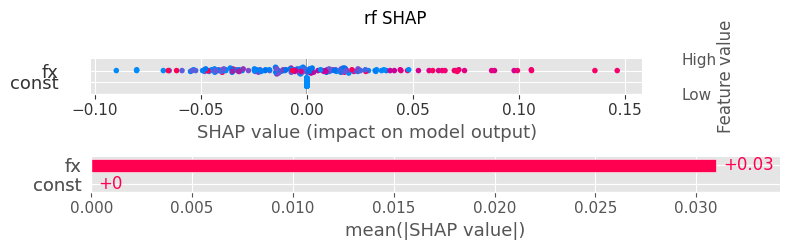

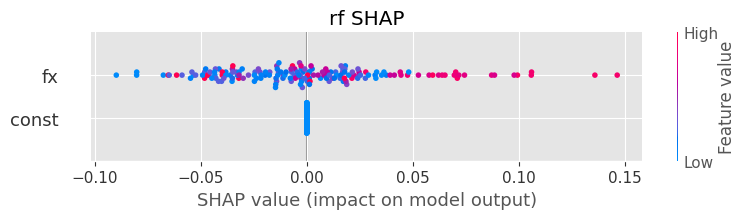


 Model: rf 
 Spec: model_2 
 Spec vars: ['fx', 'policyRate', 'bankCreditPnfs_yoy_L2', 'cpi_yoy_L1'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:22:50 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 

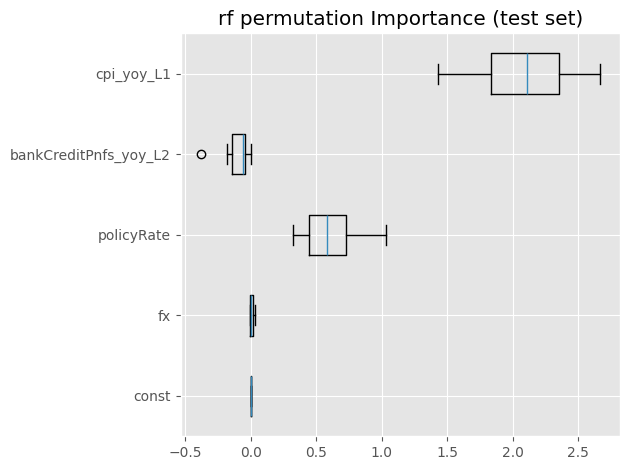

 94%|=================== | 163/173 [00:14<00:00]       

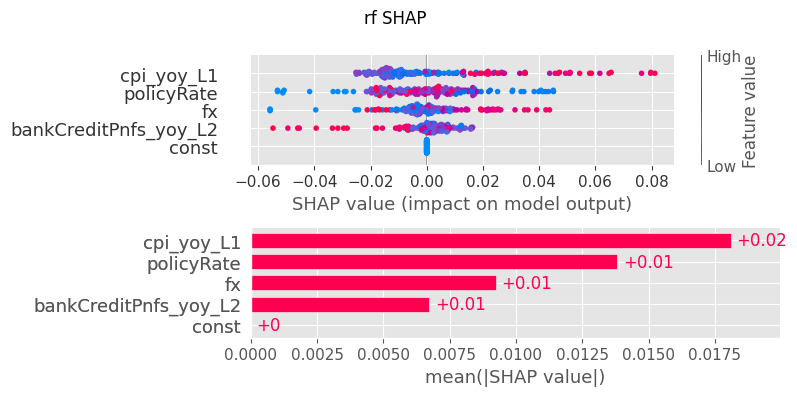

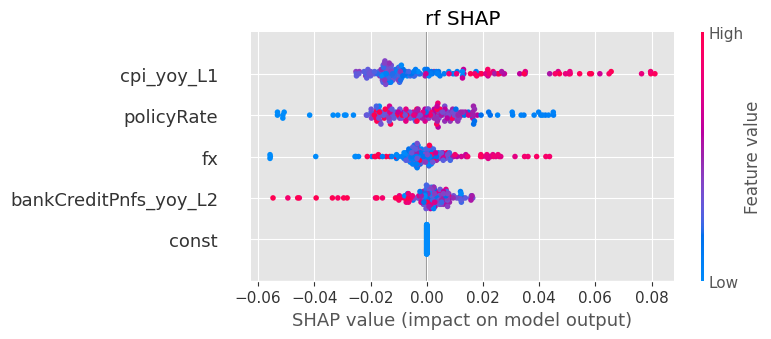


 Model: rf 
 Spec: model_3 
 Spec vars: ['fx', 'policyRate'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:23:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 

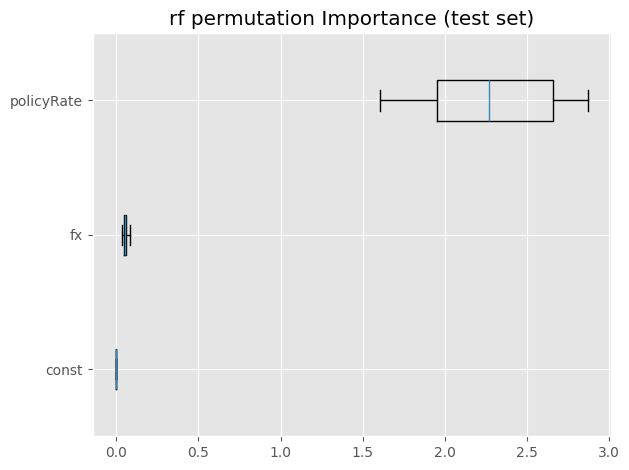

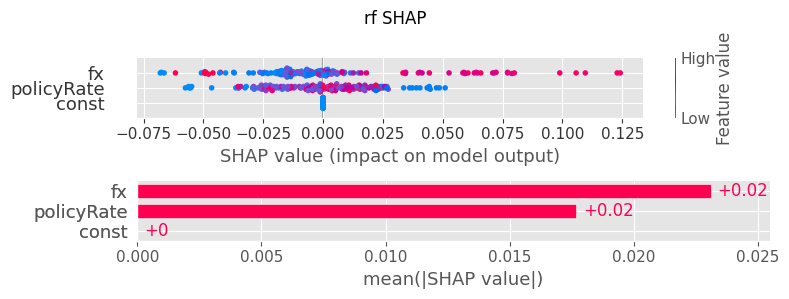

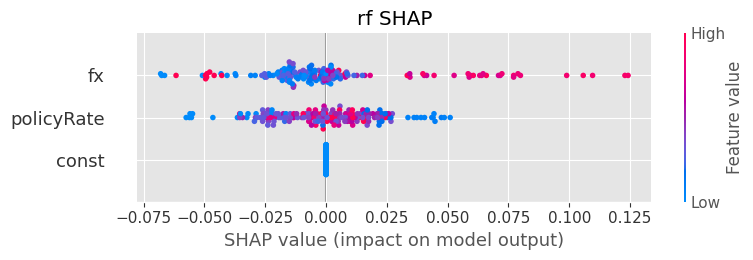


 Model: rf 
 Spec: model_4 
 Spec vars: ['fx', 'bankCreditPnfs_yoy_L2'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:23:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 

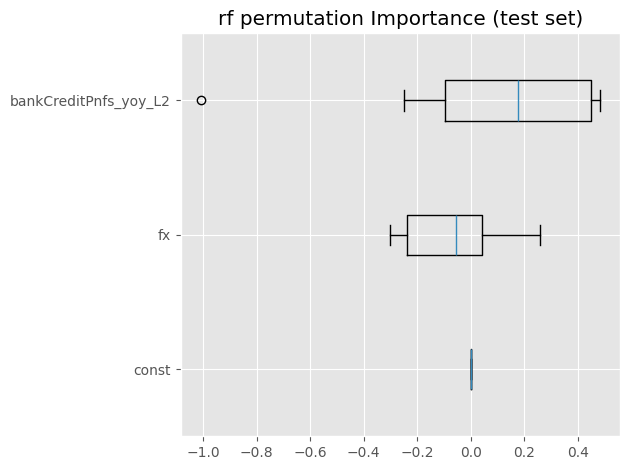

 92%|==================  | 160/173 [00:11<00:00]       

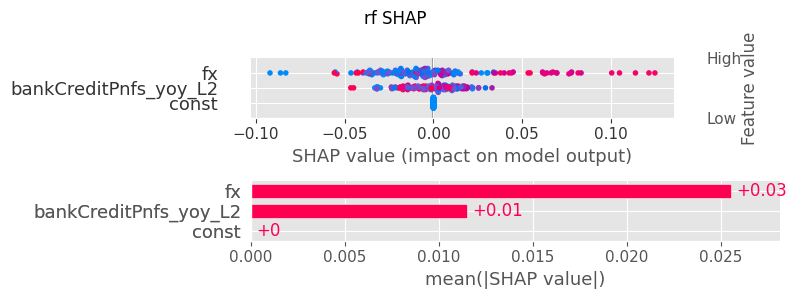

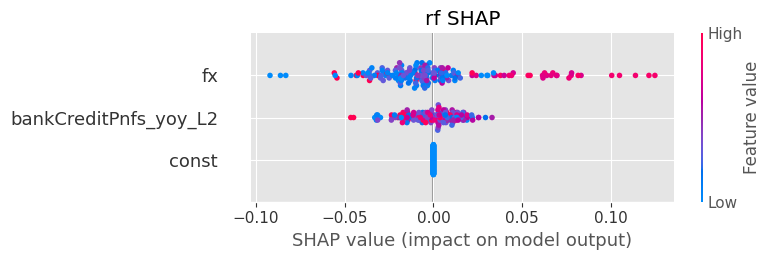


 Model: xgb 
 Spec: model_1 
 Spec vars: ['fx'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:24:03 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 

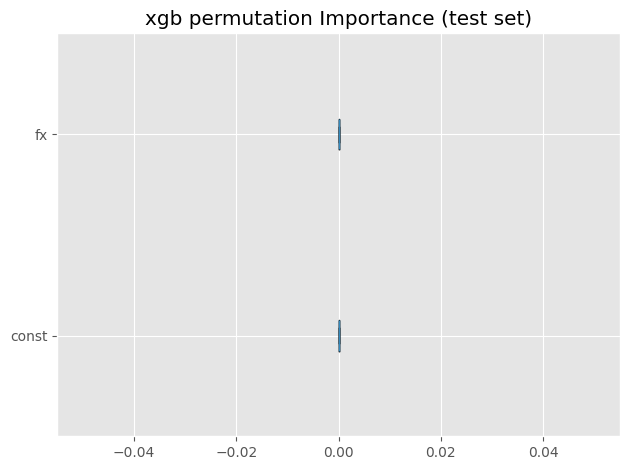

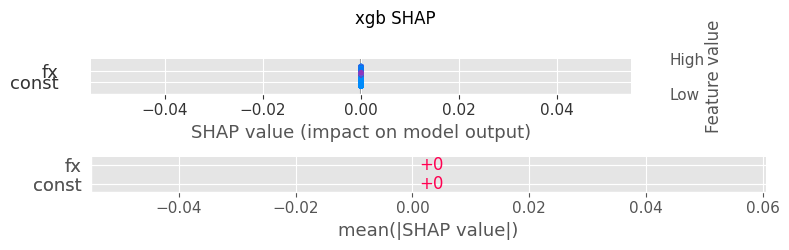

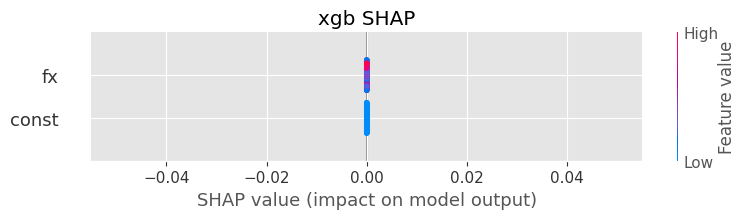


 Model: xgb 
 Spec: model_2 
 Spec vars: ['fx', 'policyRate', 'bankCreditPnfs_yoy_L2', 'cpi_yoy_L1'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:24:10 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 

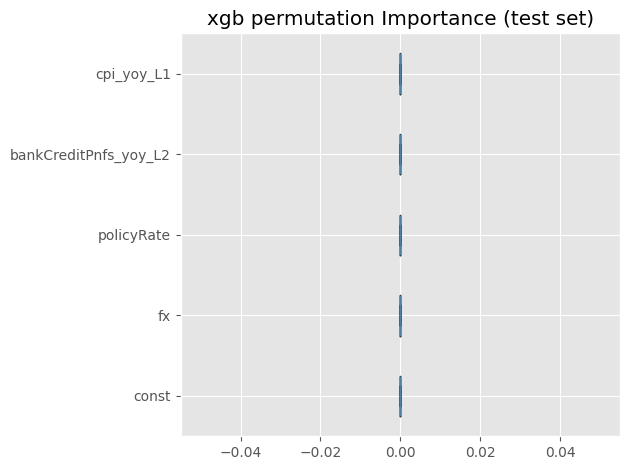

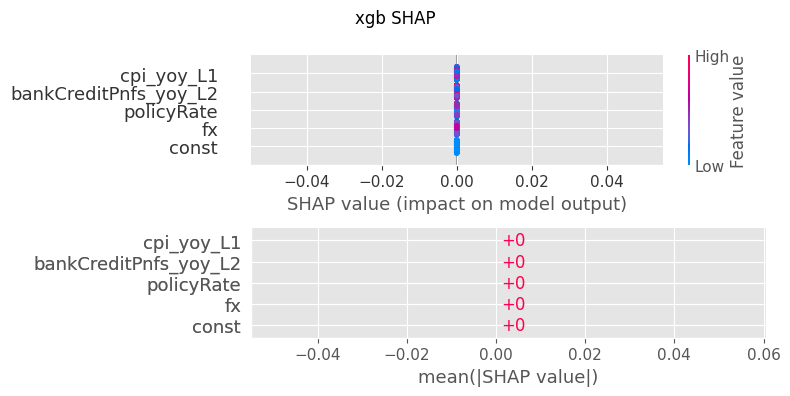

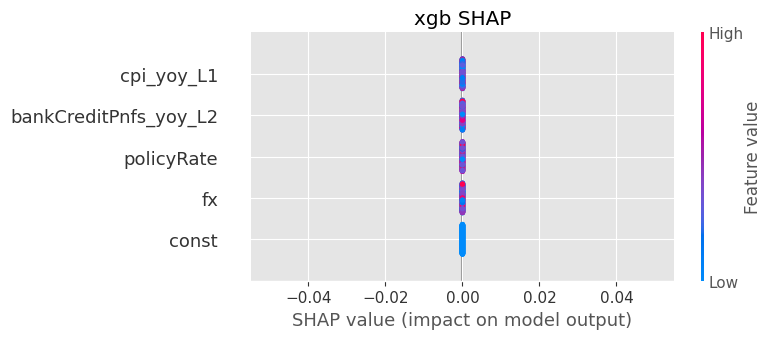


 Model: xgb 
 Spec: model_3 
 Spec vars: ['fx', 'policyRate'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:24:17 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 

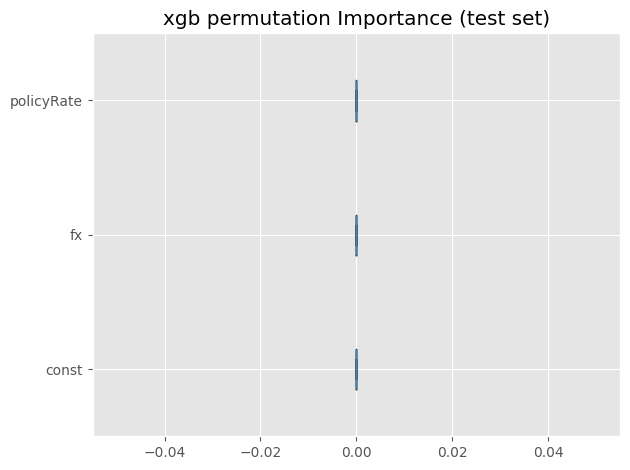

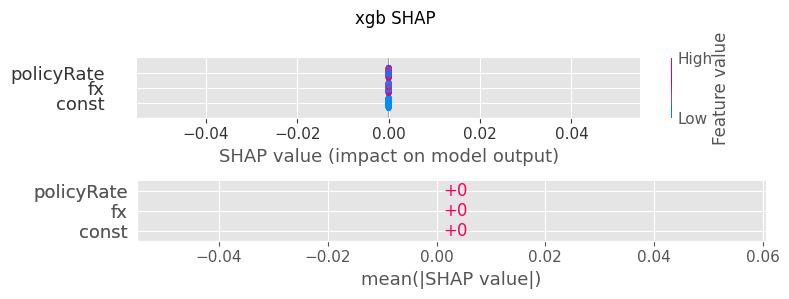

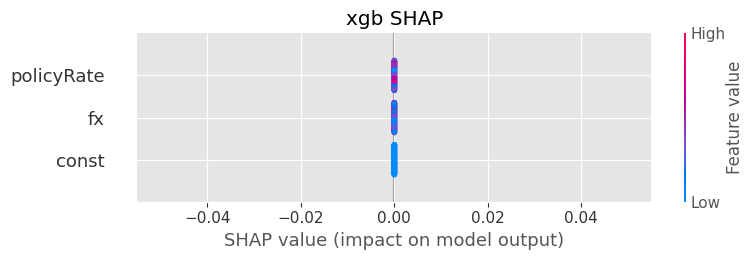


 Model: xgb 
 Spec: model_4 
 Spec vars: ['fx', 'bankCreditPnfs_yoy_L2'] 
 Horizon: movingAveragem


c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
2024/07/29 18:24:23 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
c:\Users\al005366\Envs\eu_sdfa\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will 

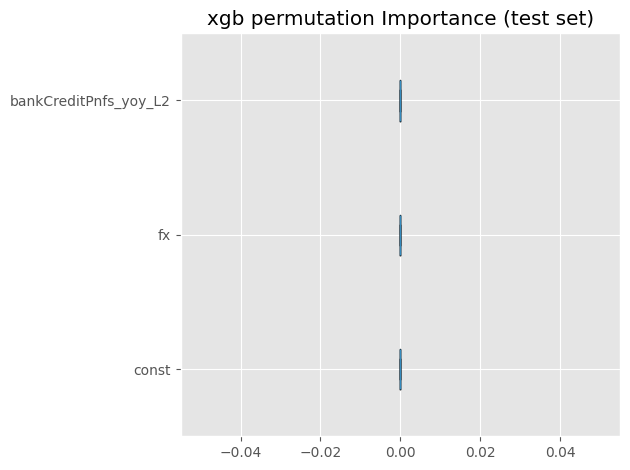

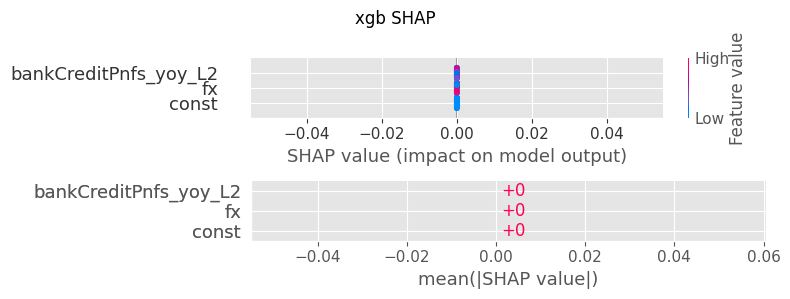

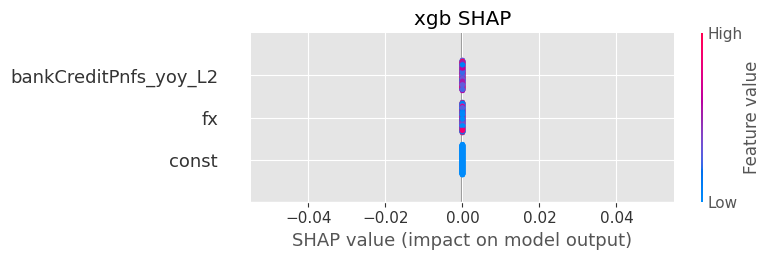

Experiment completed and logged.


In [18]:
benchmarking_dict = {
    'ols': {'model': None, 'param_grid': None},
    #'var': {'model': None, 'param_grid': None},
    #'ridge': {'model': ridge_model, 'param_grid': ridge_params_grid},
  #  'kernel_ridge': {'model': kernel_ridge_model, 'param_grid': kr_params_grid},
    'rf': {'model': rf_model, 'param_grid': rf_params_grid},
  #  'gbr': {'model': gbr_model, 'param_grid': gbr_params_grid},
    'xgb': {'model': xgb_model, 'param_grid': xgb_params_grid},
   # 'mlp': {'model': mlp_model, 'param_grid': mlp_params_grid}
}

# Specify horizons and metrics
horizon = ['1m', '3m', '12m']
metric = ['r2', 'rmse_1', 'rmse_2']

# Create a dictionary to store results
res = dict()

# Loop through each model for benchmarking
for model in benchmarking_dict.keys():
    # Initialize results dataframe         
    res[model] = pd.DataFrame(index=models.keys(), columns=pd.MultiIndex.from_product([horizon, metric], names=['horizon','metric']))
    # Loop through each target horizon
    for h in train_y.columns:
        hh = h.split('_')[-1].split('F')[-1] + 'm'
        # Loop through each model specification
        for modname, modvars in models.items():
            # Start an MLflow run
            with mlflow.start_run(run_name=f"Stress Index-{today_str}-{model}-{h}-{modname}", experiment_id=experiment_id):
                # Logging information    
                print(f'\n Model: {model} \n Spec: {modname} \n Spec vars: {modvars} \n Horizon: {hh}')
                mlflow.log_param("Model", model)
                mlflow.log_param("Spec", modname)
                mlflow.log_param("Spec_vars", modvars)
               # mlflow.log_param("Horizon", hh)
                
                if model == 'ols':
                    ols_model = sm.OLS(train_y[h], train_x[modname])
                    res_fit = ols_model.fit()
                 #   pred_o = res_fit.predict(sm.add_constant(test_x[modname][train_x[modname].columns]))
                    pred_o_1 = res_fit.predict(sm.add_constant(test_x_1[modname][train_x[modname].columns]))
                  #  pred_o_2 = res_fit.predict(sm.add_constant(test_x_2[modname][train_x[modname].columns]))
                    pred_i = res_fit.predict(sm.add_constant(train_x[modname]))
                    best_params = None
                elif model == 'var':
                    cols2var = modvars  # Use current model's variables for VAR
                    train_data = df_train[cols2var].dropna().copy()
                    test_data = df_test[cols2var].dropna().copy()
                    var_model = VAR(train_data)
                    res_fit = var_model.fit(1)
                 #   pred_o = res_fit.forecast(train_data.values[-1:], len(test_data))
                    pred_o_1 = res_fit.forecast(train_data.values[-1:], len(df_test_1[cols2var].dropna()))
                 #   pred_o_2 = res_fit.forecast(train_data.values[-1:], len(df_test_2[cols2var].dropna()))
                    pred_i = res_fit.fittedvalues
                    best_params = None
                else:
                    # Grid search for hyperparameter tuning
                    model_paramSearch = GridSearchCV(benchmarking_dict[model]['model'], 
                                                    param_grid=benchmarking_dict[model]['param_grid'],
                                                    cv=tscv)
                    model_paramSearch.fit(train_x[modname], train_y[h])
                    best_params = model_paramSearch.best_params_
                    
                    # Fit the model with the best hyperparameters
                    res_fit = benchmarking_dict[model]['model'].set_params(**model_paramSearch.best_params_).fit(train_x[modname], train_y[h])

                    # Make predictions on test data
               #     pred_o = res_fit.predict(test_x[modname])
                    pred_o_1 = res_fit.predict(test_x_1[modname])
               #     pred_o_2 = res_fit.predict(test_x_2[modname])
                    pred_i = res_fit.predict(train_x[modname])
                
                # Log the resulting model
                mlflow.sklearn.log_model(res_fit, "model")

                # Log the best parameters
                if best_params:
                    for param, value in best_params.items():
                        mlflow.log_param(param, value)
                
                try:
                    coeff_ = pd.DataFrame(res_fit.params, index=train_x[modname].columns, columns=['coeff'])
                except Exception:
                    coeff_ = []
                
                # Calculate evaluation metrics
                r2 = r2_score(train_y[h], pred_i)
                rmse_1 = mean_squared_error(test_y_1, pred_o_1, squared=False)
             #   rmse_2 = mean_squared_error(test_y_2, pred_o_2, squared=False)
                res[model].loc[modname, (hh, 'r2')] = r2
                res[model].loc[modname, (hh, 'rmse_1')] = rmse_1
            #    res[model].loc[modname, (hh, 'rmse_2')] = rmse_2

                # Log metrics
                mlflow.log_metric("r2", r2)
                mlflow.log_metric("rmse_1", rmse_1)
              #  mlflow.log_metric("rmse_2", rmse_2)

                           # Compute and log permutation importance if applicable
                if model not in ['ols', 'var']:
                    perm_imp = permutation_importance(res_fit, test_x[modname], test_y, n_repeats=10, random_state=0, n_jobs=2)
                    perm_imp_df = pd.DataFrame(perm_imp.importances[:].T, columns=test_x[modname].columns)
                    
                    with tempfile.NamedTemporaryFile(suffix=".csv", delete=False) as tempf:
                        perm_imp_df.to_csv(tempf.name, index=False)
                        mlflow.log_artifact(tempf.name, "permutation_importance.csv")
                
                    # Plot permutation importance
                    plt.boxplot(perm_imp_df, vert=False, labels=perm_imp_df.columns)
                    plt.title(f"{model} permutation Importance (test set)")
                    plt.tight_layout()
                    plt.savefig(f"{model}_perm_imp_{modname}.png")
                    plt.show()

                # Compute and log SHAP values if applicable
                if model not in ['ols', 'var']:
                    try:
                        if model == "rf":
                            explainer = shap.Explainer(res_fit, train_x[modname])
                
                        elif model == 'ridge':
                            explainer = shap.Explainer(res_fit, train_x[modname])
                        elif model == 'kernel_ridge':
                            explainer = shap.KernelExplainer(res_fit.predict, train_x[modname])
                        elif model == 'mlp':
                            explainer = shap.KernelExplainer(res_fit.predict, train_x[modname])
                        else:
                            explainer = shap.Explainer(res_fit)
                        
                        shap_values = explainer(train_x[modname])
                        shap_values_test = explainer(test_x[modname])
                        
                        plt.subplot(211)
                        shap.plots.beeswarm(shap_values, show=False, max_display=10)
                        plt.subplot(212)
                        shap.plots.bar(shap_values, show=False, max_display=10)
                        plt.suptitle(f"{model} SHAP")
                        plt.tight_layout()
                        plt.savefig(f"{model}_shap_{modname}.png")
                        plt.show()

                        shap.summary_plot(shap_values, train_x[modname], show=False)
                        plt.title(f"{model} SHAP")
                        plt.tight_layout()
                        plt.savefig(f"{model}_shapSummary_{modname}.png")
                        plt.show()
                        
                        # Save SHAP values
                        shap_values_df = pd.DataFrame(shap_values.values, columns=train_x[modname].columns)
                        with tempfile.NamedTemporaryFile(suffix=".csv", delete=False) as tempf:
                            shap_values_df.to_csv(tempf.name, index=False)
                            mlflow.log_artifact(tempf.name, "shap_values.csv")

                    except Exception as e:
                        print(e)
                # Save results to a pickle file
                res2pkl = {
                    'fit': res_fit,
                  #  'pred_o': pred_o,
                    'pred_o_1': pred_o_1,
                 #   'pred_o_2': pred_o_1,
                    'train_x': train_x[modname],
                #    'test_x': test_x[modname],
                    'test_x_1': test_x_1[modname],
                #    'test_x_2': test_x_2[modname],
                    'train_y': train_y[h],
                 #   'test_y': test_y,
                    'test_y_1': test_y_1,
                #    'test_y_2': test_y_2,
                    'pred_i': pred_i,
                    'coeff_': coeff_,
                    'r2': res[model].loc[modname, (hh, 'r2')],
                    'rmse_1': res[model].loc[modname, (hh, 'rmse_1')],
                 #   'rmse_2': res[model].loc[modname, (hh, 'rmse_2')],
                    'permutation_importance': perm_imp_df if model not in ['ols', 'var'] else None,
                    'shap': shap_values.values if model not in ['ols', 'var'] else None
                }
            
            #with open(f'{models_folder}{model}\\{model}_{modname}_{hh}.pkl','wb') as f:
            #    pickle.dump(res2pkl, f)
    
    # Save results to an Excel file        
    #res[model].to_excel(res_folder + f'{model}_V2.xlsx', sheet_name='data')

# Save overall results to a pickle file               
#with open(res_folder + '\\results_models_V2.pkl', 'wb') as f:
#    pickle.dump(res, f)

print("Experiment completed and logged.")

